# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

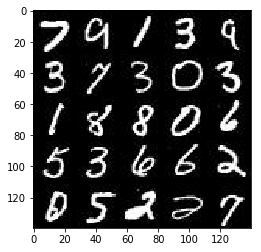

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

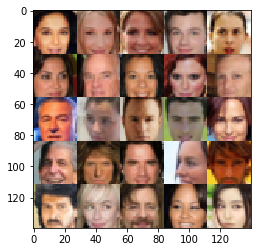

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    # Define placeholder for image details
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_image')
    
    # Define placeholder for image z dim
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')

    # Define placeholder for learning rate
    input_learning_rate = tf.placeholder(tf.float32, (None), name='input_learning_rate')

    return input_real, input_z, input_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # Image input is 28x28x(1 or 3)
    width = 28
    # Starting filter depth is hard set to 32
    depth = 32
    
    # Define alpha for relu
    alpha = 0.1
    
    # Reuse variables 
    with tf.variable_scope('discriminator', reuse=reuse):
        #First Fully connected layer
        layer1 = tf.layers.conv2d(images, depth, 5, strides=2, padding='same')
        # Define leaky relu (don't normalize)
        relu1 = tf.maximum(alpha*layer1, layer1)
        # Data is 14x14x32
        
        # Double the filter depth
        depth = int(2*depth)
        
        # Define second conv layer in stack
        layer2 = tf.layers.conv2d_transpose(relu1, depth, 5, strides=2, padding='same')
        # Normalize layer
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        # Define leaky relu (don't normalize)
        relu2 = tf.maximum(alpha*layer2, layer2)
        # Data is 7x7x64     
        
        # Double the filter depth
        depth = int(2*depth)
        
        # Define third conv layer in stack
        layer3 = tf.layers.conv2d_transpose(relu2, depth, 5, strides=2, padding='same')
        # Normalize layer
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        # Define leaky relu (don't normalize)
        relu3 = tf.maximum(alpha*layer3, layer3)
        # Data is 4x4x128      
        
        # Double the filter depth
        depth = int(2*depth)
        
        # Define fourth conv layer in stack
        layer4 = tf.layers.conv2d_transpose(relu3, depth, 5, strides=2, padding='same')
        # Normalize layer
        layer4 = tf.layers.batch_normalization(layer4, training=True)
        # Define leaky relu (don't normalize)
        relu4 = tf.maximum(alpha*layer4, layer4)
        # Data is 2x2x256
        
        # Flatten relu
        flat = tf.reshape(relu4, (-1,2*2*depth))
        # Calculate logits and output
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # Incoming filter depth 
    depth = 512
    
    # Define alpha for relu
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse = not is_train):
        # Data in is 4x4x128      

        # First fully connected layer
        layer1 = tf.layers.dense(z, 4*4*depth)
        # Reshape the layer for first conv layer in stack
        layer1 = tf.reshape(layer1, (-1,4,4,depth))
        # Normalize layer
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        # Define leaky relu
        layer1 = tf.maximum(alpha*layer1, layer1)
        # Data is 4x4x512
        
        # Quarter the filter depth
        depth = int(depth/4)

        # Define second conv layer in stack
        layer2 = tf.layers.conv2d_transpose(layer1, depth, 4, strides=1, padding='valid')
        # Normalize layer
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        # Define leaky relu
        layer2 = tf.maximum(alpha*layer2, layer2)
        # Data is 8x8x128
        
        # Halve the filter depth
        depth = int(depth/2)
        
        # Define third conv layer in stack
        layer3 = tf.layers.conv2d_transpose(layer2, depth, 5, strides=2, padding='same')
        # Normalize layer
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        # Define leaky relu
        layer3 = tf.maximum(alpha*layer3, layer3)
        # Data is 16x16x64
        
        # Halve the filter depth
        depth = int(depth/2)
        
        # Define third conv layer in stack
        layer4 = tf.layers.conv2d_transpose(layer3, depth, 5, strides=2, padding='same')
        # Normalize layer
        layer4 = tf.layers.batch_normalization(layer4, training=is_train)
        # Define leaky relu
        layer4 = tf.maximum(alpha*layer4, layer4)
        # Data is 32x32x32
        
        # Output layer
        logits = tf.layers.conv2d_transpose(layer4, out_channel_dim, 3, strides=1, padding='same')
        # Data is  32x32x3

        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Create generator model
    g_model = generator(input_z, out_channel_dim)
    # Create discriminator models
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calc d loss - include smoothing in real
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    # Sum real and fake d loss
    d_loss = d_loss_real + d_loss_fake
    
    # Calc g loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):

        # Optimize
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Split out the shape data
    _, img_width, img_height, img_channels = data_shape
    
    # Create the inputs - data shape is number of images, image_width, image_height, image_channels
    in_real, in_z, in_lr = model_inputs(img_width, img_height, img_channels, z_dim)

    # Set up losses
    d_loss, g_loss = model_loss(in_real, in_z, img_channels)
            
    # Set up optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Keep track of steps
    steps = 0
    # Define how often to print and show output
    print_output = 10
    show_output = 100
    
    # Create saver object
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # Increment steps
                steps += 1
                
                # Double image values to -1,1
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers for session
                _ = sess.run(d_opt, feed_dict={in_real: batch_images, in_z: batch_z, in_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={in_z: batch_z, in_lr: learning_rate})
                
                # Print loss output every x steps
                if steps % print_output == 0:
                    # Calculate loss per session
                    d_loss_train = d_loss.eval({
                        in_z: batch_z,
                        in_real: batch_images
                    })
                    g_loss_train = g_loss.eval({
                        in_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss_train),
                          "Generator Loss: {:.4f}".format(g_loss_train))
                
                # Show generator output every x steps
                if steps % show_output == 0:
                    show_generator_output(sess, 25, in_z, img_channels, data_image_mode)
                    
        saver.save(sess, './train.ckpt')



### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 1.2079
Epoch 1/2... Discriminator Loss: 1.0435... Generator Loss: 1.1647
Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.9429
Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.7928
Epoch 1/2... Discriminator Loss: 1.4884... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 0.8416
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.8276
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 0.7761
Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 1.0064
Epoch 1/2... Discriminator Loss: 1.4132... Generator Loss: 0.7394


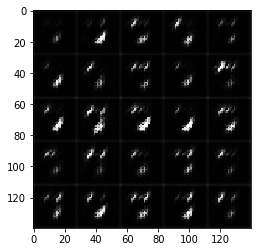

Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 0.8375
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 0.8823
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 0.8706
Epoch 1/2... Discriminator Loss: 0.8882... Generator Loss: 1.4180
Epoch 1/2... Discriminator Loss: 1.2436... Generator Loss: 0.8552
Epoch 1/2... Discriminator Loss: 1.5035... Generator Loss: 0.7337
Epoch 1/2... Discriminator Loss: 1.4341... Generator Loss: 0.6572
Epoch 1/2... Discriminator Loss: 1.4104... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 0.7605
Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 1.0075


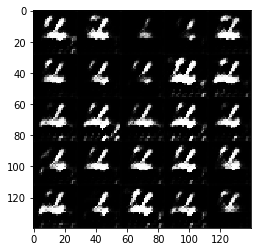

Epoch 1/2... Discriminator Loss: 1.4471... Generator Loss: 0.7158
Epoch 1/2... Discriminator Loss: 1.1582... Generator Loss: 0.9336
Epoch 1/2... Discriminator Loss: 1.6312... Generator Loss: 1.7813
Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 0.9781
Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 0.8929
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.6956
Epoch 1/2... Discriminator Loss: 1.2223... Generator Loss: 0.8967
Epoch 1/2... Discriminator Loss: 1.2869... Generator Loss: 0.7440
Epoch 1/2... Discriminator Loss: 1.2497... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 0.8136


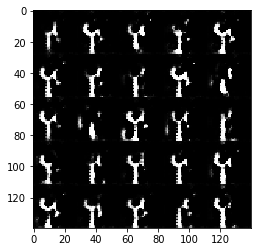

Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 0.9600
Epoch 1/2... Discriminator Loss: 1.1877... Generator Loss: 0.8851
Epoch 1/2... Discriminator Loss: 1.6445... Generator Loss: 0.3546
Epoch 1/2... Discriminator Loss: 1.3174... Generator Loss: 0.8335
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 0.8242
Epoch 1/2... Discriminator Loss: 1.2193... Generator Loss: 1.1262
Epoch 1/2... Discriminator Loss: 1.2893... Generator Loss: 0.6453
Epoch 1/2... Discriminator Loss: 1.4709... Generator Loss: 0.8523
Epoch 1/2... Discriminator Loss: 1.8433... Generator Loss: 1.8928
Epoch 1/2... Discriminator Loss: 1.3338... Generator Loss: 0.9828


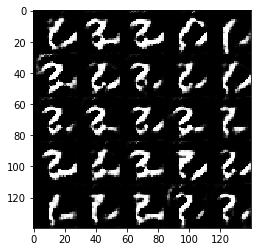

Epoch 1/2... Discriminator Loss: 1.1968... Generator Loss: 1.0935
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 0.5421
Epoch 1/2... Discriminator Loss: 1.3259... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 1.4641... Generator Loss: 0.8305
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 1.2992... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.3155... Generator Loss: 0.9386
Epoch 1/2... Discriminator Loss: 1.2748... Generator Loss: 0.8504
Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 1.3629
Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.9219


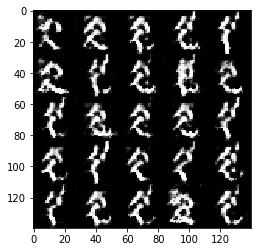

Epoch 1/2... Discriminator Loss: 1.3016... Generator Loss: 0.8407
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 0.7952
Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 0.8159
Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 1.4860... Generator Loss: 0.4891
Epoch 1/2... Discriminator Loss: 1.3394... Generator Loss: 0.5973
Epoch 1/2... Discriminator Loss: 1.3152... Generator Loss: 0.6632
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 0.6769
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 1.1067
Epoch 1/2... Discriminator Loss: 1.1855... Generator Loss: 0.8722


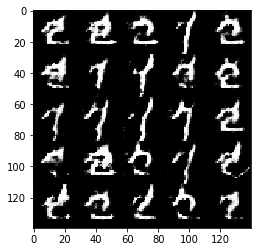

Epoch 1/2... Discriminator Loss: 1.3261... Generator Loss: 0.8079
Epoch 1/2... Discriminator Loss: 1.2497... Generator Loss: 1.0347
Epoch 1/2... Discriminator Loss: 1.5371... Generator Loss: 1.5981
Epoch 1/2... Discriminator Loss: 1.2636... Generator Loss: 0.9208
Epoch 1/2... Discriminator Loss: 1.3265... Generator Loss: 0.9109


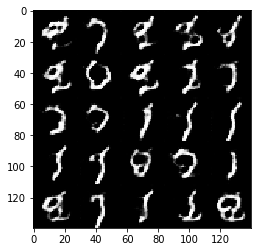

Epoch 1/2... Discriminator Loss: 1.2327... Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 0.7622
Epoch 1/2... Discriminator Loss: 1.4631... Generator Loss: 0.7300
Epoch 1/2... Discriminator Loss: 1.3468... Generator Loss: 0.8066
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.8272
Epoch 1/2... Discriminator Loss: 1.2924... Generator Loss: 0.8106
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 0.9424
Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 1.2983
Epoch 1/2... Discriminator Loss: 1.3544... Generator Loss: 0.8758
Epoch 1/2... Discriminator Loss: 1.4315... Generator Loss: 0.7153


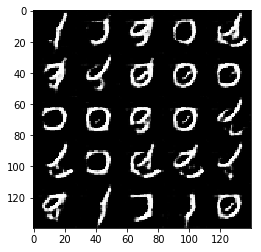

Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 1.0014
Epoch 1/2... Discriminator Loss: 1.1421... Generator Loss: 0.9494
Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 0.6634
Epoch 1/2... Discriminator Loss: 1.1833... Generator Loss: 0.8425
Epoch 1/2... Discriminator Loss: 1.5172... Generator Loss: 0.5994
Epoch 1/2... Discriminator Loss: 1.2086... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.9303
Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 1.0696
Epoch 1/2... Discriminator Loss: 1.4299... Generator Loss: 0.7894
Epoch 1/2... Discriminator Loss: 1.5665... Generator Loss: 1.5724


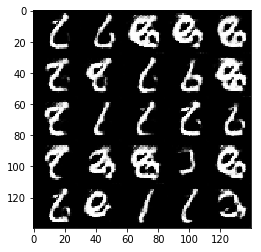

Epoch 1/2... Discriminator Loss: 1.4740... Generator Loss: 1.0183
Epoch 1/2... Discriminator Loss: 1.3416... Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 1.3158... Generator Loss: 0.7931
Epoch 2/2... Discriminator Loss: 1.2242... Generator Loss: 0.9511
Epoch 2/2... Discriminator Loss: 1.3538... Generator Loss: 0.8666
Epoch 2/2... Discriminator Loss: 1.1625... Generator Loss: 1.0585
Epoch 2/2... Discriminator Loss: 1.4509... Generator Loss: 0.5730
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 1.0614
Epoch 2/2... Discriminator Loss: 1.4598... Generator Loss: 1.1617
Epoch 2/2... Discriminator Loss: 1.3001... Generator Loss: 0.7936


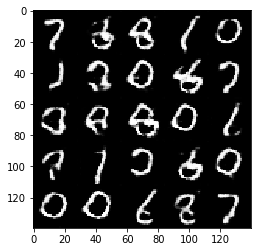

Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 0.8046
Epoch 2/2... Discriminator Loss: 1.2716... Generator Loss: 0.8794
Epoch 2/2... Discriminator Loss: 1.4274... Generator Loss: 1.0090
Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 0.5110
Epoch 2/2... Discriminator Loss: 1.1863... Generator Loss: 0.8672
Epoch 2/2... Discriminator Loss: 1.4146... Generator Loss: 0.7104
Epoch 2/2... Discriminator Loss: 1.4073... Generator Loss: 0.7033
Epoch 2/2... Discriminator Loss: 1.3495... Generator Loss: 0.7524
Epoch 2/2... Discriminator Loss: 1.4492... Generator Loss: 0.5408
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.8128


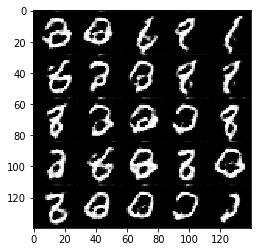

Epoch 2/2... Discriminator Loss: 1.4084... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 1.2892... Generator Loss: 0.8762
Epoch 2/2... Discriminator Loss: 1.3007... Generator Loss: 1.1497
Epoch 2/2... Discriminator Loss: 1.4342... Generator Loss: 1.1424
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 1.0585
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 0.8867
Epoch 2/2... Discriminator Loss: 1.4151... Generator Loss: 0.9688
Epoch 2/2... Discriminator Loss: 1.5395... Generator Loss: 1.5470
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.8803


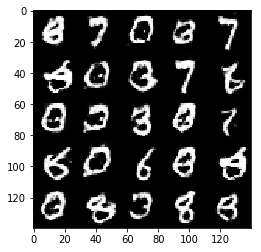

Epoch 2/2... Discriminator Loss: 1.3157... Generator Loss: 0.7150
Epoch 2/2... Discriminator Loss: 1.3313... Generator Loss: 0.9881
Epoch 2/2... Discriminator Loss: 1.3189... Generator Loss: 0.7143
Epoch 2/2... Discriminator Loss: 1.3956... Generator Loss: 1.1579
Epoch 2/2... Discriminator Loss: 1.5016... Generator Loss: 0.7338
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.6429
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 0.5947
Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 0.8957
Epoch 2/2... Discriminator Loss: 1.4001... Generator Loss: 0.6991


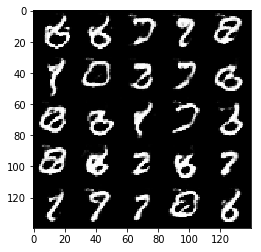

Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.7746
Epoch 2/2... Discriminator Loss: 1.2743... Generator Loss: 0.8843
Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.8178
Epoch 2/2... Discriminator Loss: 1.3589... Generator Loss: 0.8651
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 1.5474
Epoch 2/2... Discriminator Loss: 1.2979... Generator Loss: 0.8006
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 1.4971
Epoch 2/2... Discriminator Loss: 1.2757... Generator Loss: 0.9171
Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 0.8797
Epoch 2/2... Discriminator Loss: 1.4416... Generator Loss: 0.4521


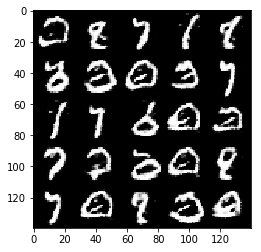

Epoch 2/2... Discriminator Loss: 1.4374... Generator Loss: 0.5098
Epoch 2/2... Discriminator Loss: 1.2712... Generator Loss: 1.0184
Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 0.6815
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.9621
Epoch 2/2... Discriminator Loss: 1.5134... Generator Loss: 1.4831
Epoch 2/2... Discriminator Loss: 1.2942... Generator Loss: 0.9275
Epoch 2/2... Discriminator Loss: 1.2918... Generator Loss: 0.8577
Epoch 2/2... Discriminator Loss: 1.2565... Generator Loss: 0.9243
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.7056
Epoch 2/2... Discriminator Loss: 1.2638... Generator Loss: 0.7078


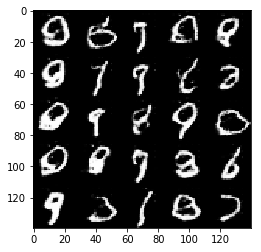

Epoch 2/2... Discriminator Loss: 1.4364... Generator Loss: 1.2671
Epoch 2/2... Discriminator Loss: 1.3094... Generator Loss: 0.7951
Epoch 2/2... Discriminator Loss: 1.2902... Generator Loss: 0.7884
Epoch 2/2... Discriminator Loss: 1.5304... Generator Loss: 1.5300
Epoch 2/2... Discriminator Loss: 1.2987... Generator Loss: 0.8226
Epoch 2/2... Discriminator Loss: 1.3601... Generator Loss: 0.5196
Epoch 2/2... Discriminator Loss: 1.7759... Generator Loss: 0.2804
Epoch 2/2... Discriminator Loss: 1.3094... Generator Loss: 0.8655
Epoch 2/2... Discriminator Loss: 1.2248... Generator Loss: 0.8193
Epoch 2/2... Discriminator Loss: 1.2687... Generator Loss: 1.0943


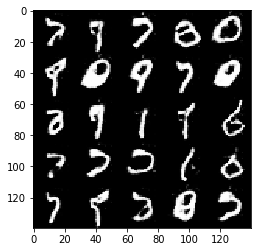

Epoch 2/2... Discriminator Loss: 1.3605... Generator Loss: 1.1114
Epoch 2/2... Discriminator Loss: 1.3371... Generator Loss: 0.5612
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 0.7841
Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 0.8125
Epoch 2/2... Discriminator Loss: 1.4641... Generator Loss: 0.4597
Epoch 2/2... Discriminator Loss: 1.3378... Generator Loss: 1.0620
Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 1.5508... Generator Loss: 1.4351
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.5155
Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.8029


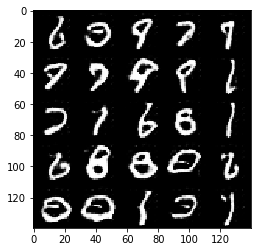

Epoch 2/2... Discriminator Loss: 1.4338... Generator Loss: 0.5041
Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 0.8415
Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 1.0199
Epoch 2/2... Discriminator Loss: 1.2831... Generator Loss: 0.8107
Epoch 2/2... Discriminator Loss: 1.3770... Generator Loss: 0.9200
Epoch 2/2... Discriminator Loss: 1.3656... Generator Loss: 0.7021
Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 1.0910
Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 1.1005
Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 0.6979
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.7790


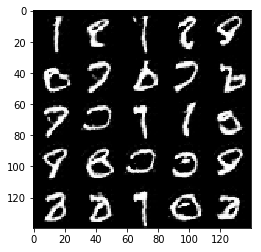

Epoch 2/2... Discriminator Loss: 1.2962... Generator Loss: 1.0117
Epoch 2/2... Discriminator Loss: 1.3178... Generator Loss: 0.6208
Epoch 2/2... Discriminator Loss: 1.4475... Generator Loss: 0.4634
Epoch 2/2... Discriminator Loss: 1.4701... Generator Loss: 0.4420
Epoch 2/2... Discriminator Loss: 1.4403... Generator Loss: 1.4203
Epoch 2/2... Discriminator Loss: 1.3375... Generator Loss: 0.6270
Epoch 2/2... Discriminator Loss: 1.4980... Generator Loss: 1.2025


ValueError: Parent directory of ./checkpoints/train.ckpt doesn't exist, can't save.

In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 1.2078
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.9848


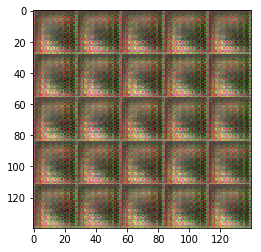

Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 1.4218
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.8360


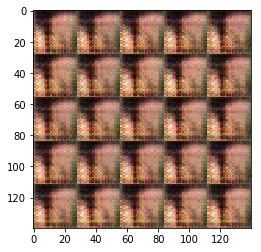

Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.9472


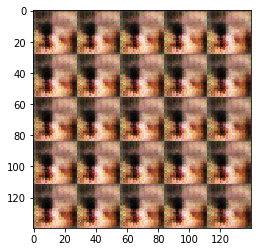

Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 1.0282
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 1.2140


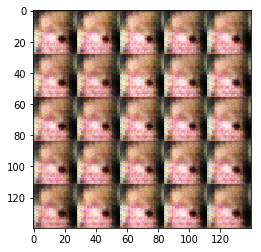

Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 1.1097
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 1.2336
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 1.2900
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 1.0754
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 1.2444


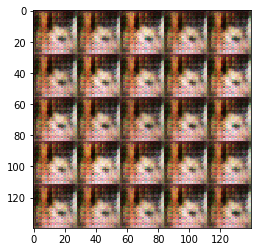

Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 1.1348
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 1.1986
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.8229


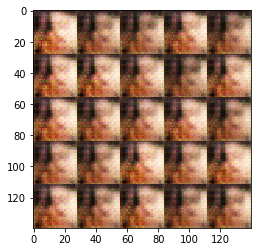

Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7048


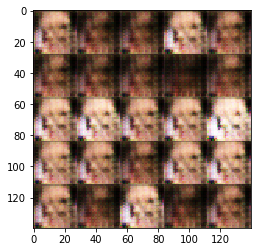

Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 1.0385


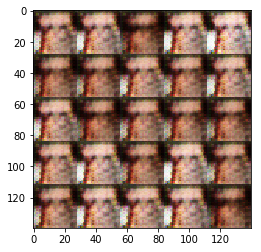

Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 1.0395
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 1.1372


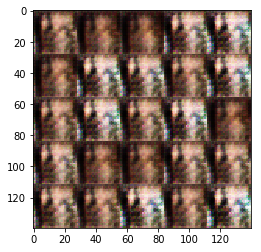

Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7005


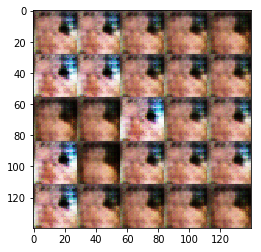

Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 1.2625
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.8650


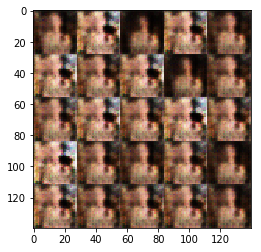

Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7570


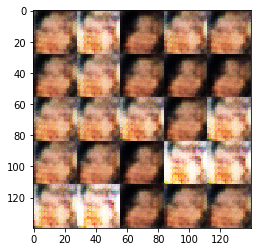

Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.7655


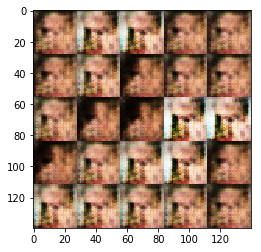

Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.8315


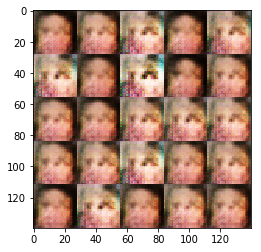

Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.9809


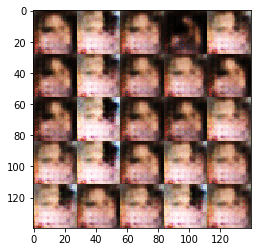

Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 1.1725
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 1.3250
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.9625
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8752


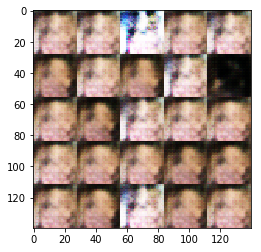

Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8131


KeyboardInterrupt: 

In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.